In [15]:
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, ReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [5]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("CNN_MLFLOW")

<Experiment: artifact_location='file:///C:/Users/maria/mlruns/3', creation_time=1733867088832, experiment_id='3', last_update_time=1733867088832, lifecycle_stage='active', name='CNN_MLFLOW', tags={}>

In [16]:
# Charger le dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values between 0 and 1 (recommanded !)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Class labels for reference
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# One-hot encoding des labels
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)



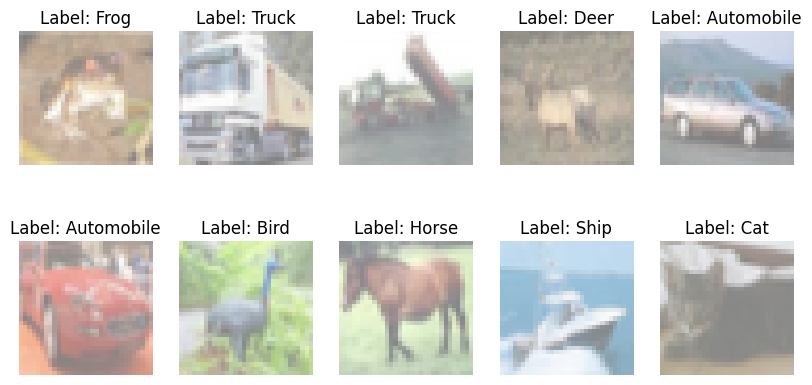

In [5]:
# Afficher quelques exemples d'images avec leurs labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((x_train[i] + 1) / 2)  # Re-normalisation pour affichage correct
    plt.title(f"Label: {class_names[y_train[i][0]]}")
    plt.axis('off')
plt.show()

In [ ]:
# Fonction pour créer un modèle CNN
def create_cnn_model(learning_rate=0.001, num_filters_1=32, num_filters_2=64, num_dense_neurons=128, dropout_rate=0.25, activation='relu'):
    model = Sequential([
        # Bloc 1
        Conv2D(num_filters_1, (3, 3), activation=activation, padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(num_filters_1, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Bloc 2
        Conv2D(num_filters_2, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        Conv2D(num_filters_2, (3, 3), activation=activation, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Classifieur
        Flatten(),
        Dense(num_dense_neurons, activation=activation),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Paramètres pour GridSearch
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'num_filters_1': [32, 64],
    'num_filters_2': [64, 128],
    'num_dense_neurons': [128, 256],
    
    'dropout_rate': [0.25, 0.5],
    'activation': ['relu', 'tanh']
}

# Initialiser MLflow
mlflow.tensorflow.autolog()

# Validation croisée 3-fold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch
best_model = None
best_accuracy = 0
best_params = None

for learning_rate in param_grid['learning_rate']:
    for num_filters_1 in param_grid['num_filters_1']:
        for num_filters_2 in param_grid['num_filters_2']:
            for num_dense_neurons in param_grid['num_dense_neurons']:
                for dropout_rate in param_grid['dropout_rate']:
                    for activation in param_grid['activation']:
                        fold_accuracies = []

                        # Suivre les expériences avec MLflow
                        with mlflow.start_run():
                            mlflow.log_param("learning_rate", learning_rate)
                            mlflow.log_param("num_filters_1", num_filters_1)
                            mlflow.log_param("num_filters_2", num_filters_2)
                            mlflow.log_param("num_dense_neurons", num_dense_neurons)
                            mlflow.log_param("dropout_rate", dropout_rate)
                            mlflow.log_param("activation", activation)

                            for train_idx, val_idx in kf.split(x_train):
                                # Diviser les données pour le fold
                                x_train_fold, x_val_fold = x_train[train_idx], x_train[val_idx]
                                y_train_fold, y_val_fold = y_train_one_hot[train_idx], y_train_one_hot[val_idx]

                                # Créer et entraîner le modèle
                                model = create_cnn_model(
                                    learning_rate, num_filters_1, num_filters_2, num_dense_neurons, dropout_rate, activation
                                )
                                history = model.fit(
                                    x_train_fold, y_train_fold,
                                    validation_data=(x_val_fold, y_val_fold),
                                    epochs=10,
                                    batch_size=64,
                                    verbose=0
                                )

                                # Enregistrer la précision du fold
                                fold_accuracy = history.history['val_accuracy'][-1]
                                fold_accuracies.append(fold_accuracy)

                            # Moyenne des précisions des folds
                            mean_accuracy = np.mean(fold_accuracies)
                            mlflow.log_metric("mean_val_accuracy", mean_accuracy)

                            # Enregistrer le meilleur modèle
                            if mean_accuracy > best_accuracy:
                                best_accuracy = mean_accuracy
                                best_model = model
                                best_params = {
                                    'learning_rate': learning_rate,
                                    'num_filters_1': num_filters_1,
                                    'num_filters_2': num_filters_2,
                                    'num_dense_neurons': num_dense_neurons,
                                    'dropout_rate': dropout_rate,
                                    'activation': activation
                                }

# Résultats du meilleur modèle
print("Meilleure précision de validation : {:.2f}%".format(best_accuracy * 100))
print("Meilleurs paramètres :", best_params)


2024/12/10 22:45:09 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
c:\Users\maria\anaconda3\envs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


2024/12/10 23:36:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-gnu-669 at: http://127.0.0.1:5000/#/experiments/3/runs/80d0848fb2c743e19b0bf27c4b95bf71.
2024/12/10 23:36:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


2024/12/11 00:26:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run bustling-skunk-747 at: http://127.0.0.1:5000/#/experiments/3/runs/c2127be44b3f486096159036c1992f39.
2024/12/11 00:26:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


2024/12/11 01:21:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run aged-rook-634 at: http://127.0.0.1:5000/#/experiments/3/runs/b945ebdf354f485fa0321db0c845e946.
2024/12/11 01:21:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


2024/12/11 02:12:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run rare-hen-656 at: http://127.0.0.1:5000/#/experiments/3/runs/4363c18b53bd456b8ec554507537dac4.
2024/12/11 02:12:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import mlflow
import mlflow.tensorflow

# Fonction pour créer un modèle CNN basé sur l'architecture donnée
def create_cnn_model(learning_rate=0.001, dropout_rate=0.25):
    model = models.Sequential([
        # Bloc 1
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 2
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 3
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 4
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Classifieur
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialiser MLflow
mlflow.tensorflow.autolog()

# Suivre l'expérience avec MLflow
with mlflow.start_run():
    # Hyperparamètres
    learning_rate = 0.001
    dropout_rate = 0.25

    # Créer le modèle
    model = create_cnn_model(learning_rate, dropout_rate)

    # # Callbacks pour un entraînement optimisé
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     restore_best_weights=True,
    #     verbose=1
    # )
    # reduce_lr = ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=3,
    #     verbose=1
    # )

    # Entraîner le modèle
    history = model.fit(
        x_train, y_train_one_hot,
        validation_split=0.2,
        epochs=2,
        batch_size=32,
        #callbacks=[early_stopping, reduce_lr],
        # verbose=1
    )

    # Évaluer le modèle
    test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # # Résultats
    # print("Précision sur les données de test : {:.2f}%".format(test_accuracy * 100))

        # Prédictions pour les métriques supplémentaires
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Enregistrer les métriques supplémentaires dans MLflow
    mlflow.log_metric("precision_macro", report['macro avg']['precision'])
    mlflow.log_metric("recall_macro", report['macro avg']['recall'])
    mlflow.log_metric("f1_macro", report['macro avg']['f1-score'])
    mlflow.log_metric("precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("f1_weighted", report['weighted avg']['f1-score'])

    # Résultats
    print("Précision sur les données de test : {:.2f}%".format(test_accuracy * 100))


    


2024/12/11 06:57:04 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
c:\Users\maria\anaconda3\envs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.3963 - loss: 1.7834

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 806s 631ms/step - accuracy: 0.3964 - loss: 1.7831 - val_accuracy: 0.6184 - val_loss: 1.1086
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 754s 603ms/step - accuracy: 0.6707 - loss: 0.9366 - val_accuracy: 0.6160 - val_loss: 1.2241
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.7439 - loss: 0.7292

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 666s 532ms/step - accuracy: 0.7439 - loss: 0.7292 - val_accuracy: 0.6932 - val_loss: 0.9243
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7887 - loss: 0.5982

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 581s 465ms/step - accuracy: 0.7887 - loss: 0.5982 - val_accuracy: 0.7952 - val_loss: 0.6090
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8230 - loss: 0.5138

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 619s 462ms/step - accuracy: 0.8230 - loss: 0.5138 - val_accuracy: 0.8114 - val_loss: 0.5800
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 582s 466ms/step - accuracy: 0.8502 - loss: 0.4301 - val_accuracy: 0.7601 - val_loss: 0.7700
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 589s 472ms/step - accuracy: 0.8713 - loss: 0.3701 - val_accuracy: 0.7812 - val_loss: 0.6749
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8944 - loss: 0.3072

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 583s 467ms/step - accuracy: 0.8944 - loss: 0.3073 - val_accuracy: 0.8199 - val_loss: 0.5682
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9099 - loss: 0.2567

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 623s 467ms/step - accuracy: 0.9099 - loss: 0.2567 - val_accuracy: 0.8390 - val_loss: 0.5363
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 645s 516ms/step - accuracy: 0.9225 - loss: 0.2213 - val_accuracy: 0.8305 - val_loss: 0.5519
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step
Classification Report:
              precision    recall  f1-score   support

    Airplane       0.84      0.87      0.85      1000
  Automobile       0.94      0.90      0.92      1000
        Bird       0.85      0.72      0.78      1000
         Cat       0.62      0.71      0.66      1000
        Deer       0.88      0.72      0.79      1000
         Dog       0.66      0.81      0.73      1000
        Frog       0.86      0.85      0.86      1000
       Horse       0.91      0.83      0.87      1000
        Ship       0.89      0.90      0.90      1000
       Truck       0.87      0.92      0.89      1000

    accuracy                           0

In [7]:
# Start MLflow run
with mlflow.start_run():
    # Log hyperparameters explicitly
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("dropout_rate", dropout_rate)

    # Train the model
    history = model.fit(
        x_train, y_train_one_hot,
        validation_split=0.2,
        epochs=1,
        batch_size=32,
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    mlflow.log_artifact("classification_report.json")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9471 - loss: 0.1517

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 669s 535ms/step - accuracy: 0.9471 - loss: 0.1518 - val_accuracy: 0.8364 - val_loss: 0.6158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


2024/12/11 10:55:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-cod-619 at: http://127.0.0.1:5000/#/experiments/3/runs/7fc7c5e88e394ce6a501d0294ca4f2f6.
2024/12/11 10:55:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/3.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
import tensorflow as tf

# Function to create a CNN model
def create_cnn_model(learning_rate=0.001, num_filters_1=32, num_filters_2=64, num_dense_neurons=512, activation='relu', dropout_rate=0.25):
    model = Sequential([ 
        
        # Convolutional Block 1
        Conv2D(num_filters_1, (3, 3), activation=activation, padding="same", input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(num_filters_1, (3, 3), activation=activation, padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Convolutional Block 2
        Conv2D(num_filters_2, (3, 3), activation=activation, padding="same"),
        BatchNormalization(),
        Conv2D(num_filters_2, (3, 3), activation=activation, padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),


        # Flatten and Fully Connected Layer
        Flatten(),
        Dense(num_dense_neurons),
        Activation(activation),

        # Output Layer
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:
# Paramètres pour GridSearch
param_grid = {
    'learning_rate': [0.001, 0.01],
    'num_neurons_1': [512, 256],
    'num_neurons_2': [256, 128],
    'activation': ['relu', 'tanh']
}


In [10]:
from tensorflow.keras.models import load_model
# Charger le modèle
model_path = "CNN_model.h5"
model = load_model(model_path)

In [12]:
print(f"Shape de y_test_one_hot: {y_test_one_hot.shape}")
print(f"Shape de la sortie modèle: {model.output_shape}")


Shape de y_test_one_hot: (10000, 10)
Shape de la sortie modèle: (None, 10)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import mlflow
import mlflow.tensorflow

# Fonction pour créer un modèle CNN basé sur l'architecture donnée
def create_cnn_model(learning_rate=0.001, dropout_rate=0.25):
    model = models.Sequential([
        # Bloc 1
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 2
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 3
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 4
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Classifieur
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Initialiser MLflow
mlflow.tensorflow.autolog()

# Suivre l'expérience avec MLflow
with mlflow.start_run():
    # Hyperparamètres
    learning_rate = 0.001
    dropout_rate = 0.25

    # Créer le modèle
    model = create_cnn_model(learning_rate, dropout_rate)


    # Entraîner le modèle
    history = model.fit(
        x_train, y_train_one_hot,
        validation_split=0.2,
        epochs=2,
        batch_size=32,
        #callbacks=[early_stopping, reduce_lr],
        # verbose=1
    )

    # Évaluer le modèle
    test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)

    # # Résultats
    # print("Précision sur les données de test : {:.2f}%".format(test_accuracy * 100))

        # Prédictions pour les métriques supplémentaires
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test_one_hot, axis=1)

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Enregistrer les métriques supplémentaires dans MLflow
    mlflow.log_metric("precision_macro", report['macro avg']['precision'])
    mlflow.log_metric("recall_macro", report['macro avg']['recall'])
    mlflow.log_metric("f1_macro", report['macro avg']['f1-score'])
    mlflow.log_metric("precision_weighted", report['weighted avg']['precision'])
    mlflow.log_metric("recall_weighted", report['weighted avg']['recall'])
    mlflow.log_metric("f1_weighted", report['weighted avg']['f1-score'])

    # Résultats
    print("Précision sur les données de test : {:.2f}%".format(test_accuracy * 100))


    


2024/12/11 11:31:24 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
c:\Users\maria\anaconda3\envs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3972 - loss: 1.7861

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 663s 520ms/step - accuracy: 0.3973 - loss: 1.7858 - val_accuracy: 0.5114 - val_loss: 1.4695
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6677 - loss: 0.9444

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 682s 546ms/step - accuracy: 0.6677 - loss: 0.9444 - val_accuracy: 0.7173 - val_loss: 0.8220
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 136ms/step


2024/12/11 11:55:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-fox-742 at: http://localhost:5000/#/experiments/3/runs/eebac288f9eb4dd09df49d7d6694babb.
2024/12/11 11:55:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


Classification Report:
              precision    recall  f1-score   support

    Airplane       0.82      0.57      0.67      1000
  Automobile       0.91      0.84      0.87      1000
        Bird       0.54      0.62      0.58      1000
         Cat       0.58      0.45      0.51      1000
        Deer       0.59      0.75      0.66      1000
         Dog       0.65      0.54      0.59      1000
        Frog       0.69      0.86      0.76      1000
       Horse       0.75      0.78      0.77      1000
        Ship       0.84      0.82      0.83      1000
       Truck       0.81      0.87      0.84      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000

Précision sur les données de test : 71.07%


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import mlflow
import mlflow.tensorflow

# Initialize MLflow
mlflow.tensorflow.autolog()

# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert class vectors to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
dropout_rate=0.25

# Define the CNN model
def create_cnn_model():
    model = models.Sequential([
       # Bloc 1
        layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 2
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 3
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Bloc 4
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Classifieur
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ])
  
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

with mlflow.start_run():
    # Create and compile the model
    model = create_cnn_model()

    # Print model summary
    model.summary()

    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=2,  # Reduced for quicker experiment
        validation_data=(x_test, y_test),
        shuffle=True
    )

    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    # Log additional metrics manually
    mlflow.log_metric("test_loss", score[0])
    mlflow.log_metric("test_accuracy", score[1])

    # Save the model
    model.save('cnn_cifar10_model.h5')
    mlflow.log_artifact('cnn_cifar10_model.h5')


2024/12/11 12:07:14 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.
c:\Users\maria\anaconda3\envs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_68          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,863,946 (10.93 MB)

 Trainable params: 2,859,722 (10.91 MB)

 Non-trainable params: 4,224 (16.50 KB)

Epoch 1/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4167 - loss: 1.7049

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 763s 480ms/step - accuracy: 0.4168 - loss: 1.7046 - val_accuracy: 0.6033 - val_loss: 1.1342
Epoch 2/2
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6935 - loss: 0.8743

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 776s 496ms/step - accuracy: 0.6935 - loss: 0.8742 - val_accuracy: 0.7316 - val_loss: 0.7917
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


Test loss: 0.7916535139083862
Test accuracy: 0.7315999865531921


2024/12/11 12:33:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-pig-584 at: http://localhost:5000/#/experiments/3/runs/0f3d2a6a8793491c9230ce29870334fd.
2024/12/11 12:33:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/3.


  0%|          | 0/498 [00:00<?, ?it/s]

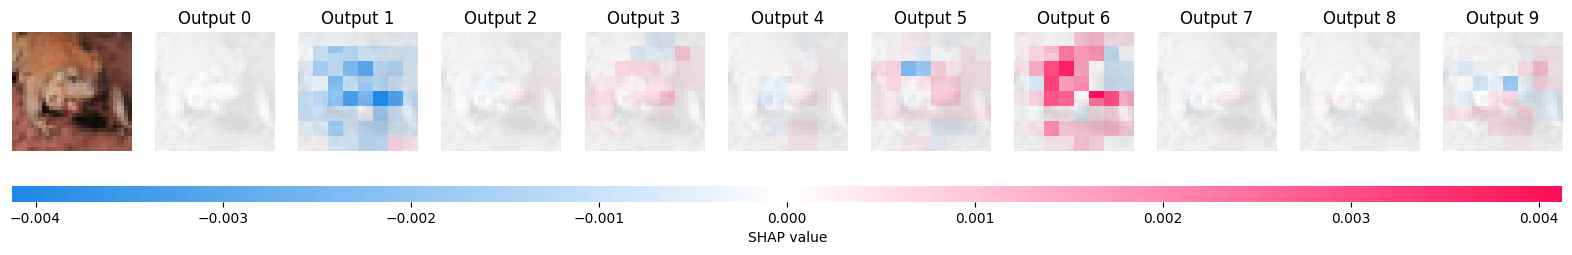

Shape de l'image à expliquer : (1, 32, 32, 3)
0.0


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Shape des données reçues pour prédiction : (10, 32, 32, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Shape des données re

IndexError: list index out of range

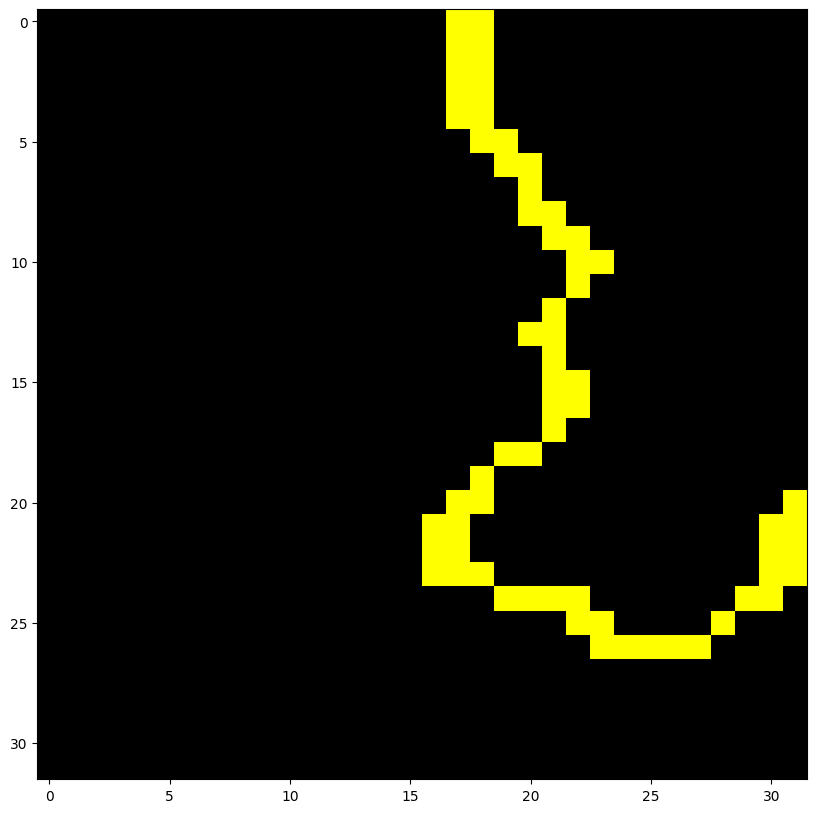

In [43]:
import shap
from shap import maskers
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Créer un masker adapté aux images (taille des images = (32, 32, 3))
masker = shap.maskers.Image(x_train[5], (32, 32, 3))

# Créer un explainer SHAP
explainer = shap.Explainer(model, masker)

# Sélectionner une image pour explication
image_to_explain = x_test[5].reshape(1, 32, 32, 3)

# Calculer les valeurs SHAP
shap_values = explainer(image_to_explain)

# Visualiser les explications
shap.image_plot(shap_values, image_to_explain)

# Vérifier la forme de l'image
print(f"Shape de l'image à expliquer : {image_to_explain.shape}")

# Créer un explainer LIME
explainer = lime_image.LimeImageExplainer()

# Sélectionner une image à expliquer
image_to_explain = x_test[5]
true_label = y_test[5][0]
print(true_label)

# Créer une fonction de prédiction
def predict_fn(images):
    # Convertir les images en tableau NumPy et s'assurer qu'elles ont 4 dimensions
    images = np.array(images)
    print(f"Shape des données reçues pour prédiction : {images.shape}")
    return model.predict(images)

# Générer une explication LIME
explanation = explainer.explain_instance(
    image_to_explain,         # L'image à expliquer
    predict_fn,               # Fonction de prédiction
    top_labels=1,             # Nombre de classes à expliquer
    hide_color=0,             # Couleur pour masquer les pixels non sélectionnés
    num_samples=1000          # Nombre d'échantillons générés
)

# Obtenir le masque pour la classe prédite
temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],  # Classe prédite
    positive_only=True,               # Montrer uniquement les pixels positifs
    num_features=10,                  # Nombre de superpixels
    hide_rest=False                   # Masquer les pixels non sélectionnés
)

# Visualiser l'explication
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explication LIME pour la classe prédite {explanation.top_labels[5]}, la classe réelle étant {true_label}")
plt.show()